In [4]:
# for the data
import pandas as pd
import numpy as np
import requests
import re

# for plotting
import matplotlib.pyplot as plt

In [610]:
# Functions used in transformation of data to make it comparable

def convert_object_columns_to_numeric(df:pd.DataFrame):
    """
    Converts all columns in a dataframe to numeric if they are numerical
    """

    if not isinstance(df, pd.DataFrame):
        raise TypeError("df should be a Pandas dataframe")

    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                pass
    return df

def inch_to_cm(height):
    
    """
    Searches for 'in' in a string and converts the value to cm
    and strips 'in' and 'cm' from the value so that it is returned as a float.
    """
    
    if 'in' in height:
        height_in_inches = float(height.replace('in', '').strip())
        return round(height_in_inches * 2.54, 1)
    elif 'cm' in height:
        return float(height.replace('cm', '').strip())
    else:
        return None

# function to convert lbs to kg
def lb_to_kg(weight):
    
    """
    Searches for 'lb' in a string and converts the value to kg
    and strips 'lb' and 'kg' from the value so that it is returned as a float.
    """
    
    # check if "lb" and a number is in the string
    if 'lb' in weight:
        weight = re.findall(r'\d+', weight)
        if len(weight) > 0:
            weight = int(weight[0])
            return round(weight / 2.20462, 1)
    elif 'kg' in weight:
        return float(weight= re.findall(r'\d+', weight))
    else:
        return None

In [357]:
def games_json_dump(year=2022, division=1, page=1):
    """
    
    This function calls Crossfits api and returns json data on different years and divisions for the Crossfit Games
    Leaderboard.

    Parameters:
        - year from 2007 until most recent
        - division is either 1 for male or 2 for female
        - page is the number of page we are on the leaderboard

    """

    # error handling for function parameters
    if not isinstance(year, int):
        raise TypeError("year should be an integer")
    if not isinstance(division, int):
        raise TypeError("division should be an integer")
    if not isinstance(page, int):
        raise TypeError("page should be an integer")

    # url for api
    url = f"https://c3po.crossfit.com/api/leaderboards/v2/competitions/games/{year}/leaderboards?division={division}&sort=0&page={page}"
    # sending the request and reading the response.
    response = requests.get(url)
    # loading the response as json
    response = response.json()
    # returing the response as a json
    return(response)

In [358]:
def games_info(year=2022, division=1):
    """
    
    This function uses the json data from the api call in games_json_dump and parses
    the json to get information on the Crossfit Games for the specified year and division 
    returned as a Pandas Dataframe.

    Parameters:
        - year from 2007 until most recent
        - division is either 1 for male or 2 for female
        - page is the number of page we are on the leaderboard

    Returns:
        - competition_id for that specified year
        - total_pages for the leaderboard
        - total_competitors for that year and division
        - total_events for that years Games

    """

    # error handling for function parameters
    if not isinstance(year, int):
        raise TypeError("year should be an integer")
    if not isinstance(division, int):
        raise TypeError("division should be an integer")
    
    # get the json data from the web service
    response = games_json_dump(year=year, division=division)
    
    # collecting data on the specified games session
    total_pages = response['pagination']['totalPages']
    total_competitors = response['pagination']['totalCompetitors']
    competition_id = response['competition']['competitionId']
    total_events = len(response['ordinals'])
    # return a list of responses
    games_info_list = [competition_id, total_pages, total_competitors, total_events]

    return(games_info_list)

In [394]:
def games_info_multiple(year_from=2018, year_too=2022, division=1):
    
    """

    This function uses the games_info function to get information on multiple Crossfit Games 
    returned as a Pandas dataframe.

    Parameters:
        - year_xxx is from 2007 and to current
        - division is 1 for male, 2 for female and 0 for both

    Returns:
        - competition_id for that specified year
        - total_pages for the leaderboard
        - total_competitors for that year and division
        - total_events for that years Games
        - year of the Games
        - division of the specified Games

    """


    # error handling for function parameters
    if not isinstance(year_from, int):
        raise TypeError("year_from should be an integer")
    if not isinstance(year_too, int):
        raise TypeError("year_too should be an integer")
    if not isinstance(division, int):
        raise TypeError("division should be an integer")
    
    # create a dataframe to store results
    df_games_info_multiple = pd.DataFrame(columns=['competitionId', 'totalPages', 'totalCompetitors', 'totalEvents', 'year','division'])
    # determining what division value we need
    if division == 1:
        division_value = [1]
    elif division == 2:
        division_value = [2]
    # else we just take both divisions
    else:
        division_value = [1,2]
    # iterate over year_from and year_too
    for i in range(0, year_too - year_from + 1):
        for j in range(0,len(division_value)):
            # results form running games_info funcation
            result_list = games_info(year_from+i,division=division_value[j])
            # results from function
            result_list.append(year_from+i)
            result_list.append(division_value[j])
            # Convert the list to a DataFrame with a single row
            temp_df = pd.DataFrame([result_list], columns=['competitionId', 'totalPages', 'totalCompetitors', 'totalEvents', 'year','division'])
            # Concatenate the DataFrame with the existing DataFrame
            df_games_info_multiple = pd.concat([df_games_info_multiple, temp_df], ignore_index=True)
    
    # transform columns into integer when relevant
    df_games_info_multiple = convert_object_columns_to_numeric(df_games_info_multiple)

    return(df_games_info_multiple)

In [406]:
df_games_info_multiple = games_info_multiple(2021,2022,0)
df_games_info_multiple

,competitionId,totalPages,totalCompetitors,totalEvents,year,division
0,161,1,40,15,2021,1
1,161,1,40,15,2021,2
2,189,1,40,14,2022,1
3,189,1,40,14,2022,2


In [393]:
df_games_info_multiple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   competitionId     4 non-null      int64
 1   totalPages        4 non-null      int64
 2   totalCompetitors  4 non-null      int64
 3   totalEvents       4 non-null      int64
 4   year              4 non-null      int64
 5   division          4 non-null      int64
dtypes: int64(6)
memory usage: 320.0 bytes


In [352]:
df_games_info_multiple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   competitionId     4 non-null      object
 1   totalPages        4 non-null      object
 2   totalCompetitors  4 non-null      object
 3   totalEvents       4 non-null      object
 4   year              4 non-null      object
 5   division          4 non-null      object
dtypes: object(6)
memory usage: 320.0+ bytes


In [403]:
def games_info_competitors(year, division):
    
    """

    This function uses the functions games_json_dump and games_info to get competitor information for 
    the specified Crossfit Games year and division returned as a Pandas dataframe.

    It also does some transformation on the data from the api. It uses the inch_to_cm and lb_to_kg functions
    to create two new columns and transforms age to integer.

    Parameters:
        - year is from 2007 and to current
        - division is 1 for male, 2 for female and 0 for both

    This functions get's a bitt more complicated when there are more than one pages per call,
    e.g. in the year 2019 when there were 144 male competitors.
    """
        
    # create a dataframe to store info
    df_games_info_competitors = pd.DataFrame()

    # determining what division value we need
    if division == 1:
        division_value = [1]
    elif division == 2:
        division_value = [2]
    # else we just take both divisions
    else:
        division_value = [1,2]

    # iterate over division_value
    for current_division in range(0,len(division_value)):
        # collecting data on the specified games session
        info_response = games_info(year=year,division=division_value[current_division])
        # iterate to solve for when pages are more than 1
        if info_response[1] > 1:
            for page in range(1, info_response[1] + 1):
                response = games_json_dump(year=year,division=division_value[current_division],page=page)
                if page == info_response[1]: # if we are on the final page
                    # call webservice to get get the json
                    for competitors_on_last_page in range(0, info_response[2] - (info_response[1] - 1) * 50): # there are currently 50 results per page
                        # parse json to where we want to be
                        entrant_json = response['leaderboardRows'][competitors_on_last_page]['entrant']
                        # insert results in temporary dataframe
                        df_temp = pd.DataFrame([entrant_json])
                        # concatenate the DataFrame with the existing DataFrame
                        df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
                else:
                    # call webservice to get get the json
                    #response = games_json_dump(year=year,division=division_value[current_division],page=page)
                    for competitor_not_on_last_page in range(0,50): # there are currently 50 results per page
                        # parse json to where we want to be
                        entrant_json = response['leaderboardRows'][competitor_not_on_last_page]['entrant']
                        # insert results in temporary dataframe
                        df_temp = pd.DataFrame([entrant_json])
                        # concatenate the DataFrame with the existing DataFrame
                        df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
        # else when total_pages on the leaderbord is just one
        else:
            # call webservice to get get the json
            response = games_json_dump(year=year,division=division_value[current_division],page=1)
            for competitor in range(0,info_response[2]):
                # parse json to where we want to be
                entrant_json = response['leaderboardRows'][competitor]['entrant']
                # insert results in temporary dataframe
                df_temp = pd.DataFrame([entrant_json])
                # Concatenate the DataFrame with the existing DataFrame
                df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
    
    # Some transfomration of the data in df_games_info_competitors
    
    # transform columns into numerical when relevant
    df_games_info_competitors = convert_object_columns_to_numeric(df_games_info_competitors)
    
    # apply the functions to the relevant columns and assign it back to the columns
    df_games_info_competitors['heightInCm'] = df_games_info_competitors['height'].apply(inch_to_cm)
    df_games_info_competitors['weightInKg'] = df_games_info_competitors['weight'].apply(lb_to_kg)
    

    return(df_games_info_competitors)

In [479]:
df_games_info_competitors = games_info_competitors(2020,1)
df_games_info_competitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   competitorId         30 non-null     int64  
 1   competitorName       30 non-null     object 
 2   firstName            30 non-null     object 
 3   lastName             30 non-null     object 
 4   status               30 non-null     object 
 5   postCompStatus       0 non-null      float64
 6   gender               30 non-null     object 
 7   profilePicS3key      30 non-null     object 
 8   countryOfOriginCode  30 non-null     object 
 9   countryOfOriginName  30 non-null     object 
 10  countryShortCode     0 non-null      float64
 11  regionId             30 non-null     object 
 12  regionName           0 non-null      float64
 13  divisionId           30 non-null     int64  
 14  affiliateId          30 non-null     object 
 15  affiliateName        30 non-null     objec

In [480]:
df_games_info_competitors.head()

,competitorId,competitorName,firstName,lastName,status,postCompStatus,gender,profilePicS3key,countryOfOriginCode,countryOfOriginName,...,regionName,divisionId,affiliateId,affiliateName,age,height,weight,teamCaptain,heightInCm,weightInKg
0,153604,Mathew Fraser,Mathew,Fraser,ACT,NaN,M,9e218-P153604_4-184.jpg,US,United States,...,NaN,1,3220,CrossFit Mayhem,30,67 in,195 lb,0,170.2,88.5
1,74320,Samuel Kwant,Samuel,Kwant,ACT,NaN,M,a9afa-P74320_4-184.jpg,US,United States,...,NaN,1,None,,24,71 in,206 lb,0,180.3,93.4
2,811708,Justin Medeiros,Justin,Medeiros,ACT,NaN,M,672d4-P811708_4-184.jpg,US,United States,...,NaN,1,1792,CrossFit Fort Vancouver,21,69 in,195 lb,0,175.3,88.5
3,2725,Noah Ohlsen,Noah,Ohlsen,ACT,NaN,M,0a0bc-P2725_5-184.jpg,US,United States,...,NaN,1,2509,Peak 360 CrossFit,29,67 in,188 lb,0,170.2,85.3
4,469656,Jeffrey Adler,Jeffrey,Adler,ACT,NaN,M,e480e-P469656_1-184.jpg,CA,Canada,...,NaN,1,18059,CrossFit Wonderland,26,69 in,197 lb,0,175.3,89.4


In [413]:
def games_info_competitor_multiple(year_from=2018, year_too=2022, division=1):
         
    """

        This function uses the games_info_competitors function to get information on Crossfit Games 
        competitors for multiple years returned as a Pandas dataframe.

        Parameters:
            - year is from 2007 and to current
            - division is 1 for male, 2 for female and 0 for both

    """   
            
    # create a dataframe to store info
    df_games_info_competitor_multiple = pd.DataFrame()
        
    # iterate over the selected years
    for year in range(year_from, year_too + 1):
        df_temp = games_info_competitors(year,division)
        df_temp['year'] = year
        df_games_info_competitor_multiple = pd.concat([df_games_info_competitor_multiple, df_temp], ignore_index=True)

    return(df_games_info_competitor_multiple)

In [414]:
df_games_info_competitors = games_info_competitor_multiple(2007,2022,0)

In [412]:
df_games_info_competitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   competitorId         1633 non-null   int64  
 1   competitorName       1633 non-null   object 
 2   firstName            1633 non-null   object 
 3   lastName             1633 non-null   object 
 4   status               1633 non-null   object 
 5   postCompStatus       0 non-null      float64
 6   gender               1633 non-null   object 
 7   profilePicS3key      1633 non-null   object 
 8   countryOfOriginCode  910 non-null    object 
 9   countryOfOriginName  910 non-null    object 
 10  countryShortCode     0 non-null      float64
 11  regionId             1633 non-null   object 
 12  regionName           747 non-null    object 
 13  divisionId           1633 non-null   int64  
 14  affiliateId          1633 non-null   object 
 15  affiliateName        1003 non-null   o

In [309]:
df_games_info_competitors[df_games_info_competitors['weightInKg'].isna()]

,competitorId,competitorName,firstName,lastName,status,postCompStatus,gender,profilePicS3key,countryOfOriginCode,countryOfOriginName,...,divisionId,affiliateId,affiliateName,age,height,weight,teamCaptain,heightInCm,weightInKg,year
7,2377125,Evan Von,Evan,Von,ACT,,M,men-square.jpg,,,...,1,None,,0,,,0,NaN,NaN,2007
8,2377126,Brent Oakson,Brent,Oakson,ACT,,M,men-square.jpg,,,...,1,None,,0,,,0,NaN,NaN,2007
14,21298,Mike Hom,Mike,Hom,ACT,,M,men-square.jpg,,,...,1,None,,24,,,0,NaN,NaN,2007
15,2377127,John Murphy,John,Murphy,ACT,,M,men-square.jpg,,,...,1,None,,0,,,0,NaN,NaN,2007
16,2377128,Ryan Wolley,Ryan,Wolley,ACT,,M,men-square.jpg,,,...,1,None,,0,,,0,NaN,NaN,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,19412,Ashley Carriveau,Ashley,Carriveau,CUT,,F,e3880-P19412_11-184.jpg,,,...,2,879,CrossFit San Jose,29,63 in,,0,160.0,NaN,2013
812,1910,Emily Beers,Emily,Beers,CUT,,F,a0653-P1910_2-184.jpg,,,...,2,889,CrossFit Vancouver,30,,,0,NaN,NaN,2014
918,21292,Anonymous Anonymous,Anonymous,Anonymous,ACT,,M,men-square.jpg,US,United States,...,1,None,,25,,,0,NaN,NaN,2016
992,21292,Anonymous Anonymous,Anonymous,Anonymous,ACT,,M,men-square.jpg,US,United States,...,1,None,,26,,,0,NaN,NaN,2017


In [296]:
df_games_info_competitors[df_games_info_competitors['competitorName'] == 'Noah Ohlsen']

,competitorId,competitorName,firstName,lastName,status,postCompStatus,gender,profilePicS3key,countryOfOriginCode,countryOfOriginName,...,divisionId,affiliateId,affiliateName,age,height,weight,teamCaptain,heightInCm,weightInKg,year
740,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,,,...,1,2509,Peak 360 CrossFit,23,67 in,190 lb,0,170.2,86.2,2014
826,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,2509,Peak 360 CrossFit,24,67 in,190 lb,0,170.2,86.2,2015
913,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,2509,Peak 360 CrossFit,25,67 in,190 lb,0,170.2,86.2,2016
983,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,None,,26,67 in,190 lb,0,170.2,86.2,2017
1063,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,7104,CrossFit Passion,27,67 in,190 lb,0,170.2,86.2,2018
1139,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,2509,Peak 360 CrossFit,28,67 in,190 lb,0,170.2,86.2,2019
1416,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,2509,Peak 360 CrossFit,29,67 in,188 lb,0,170.2,85.3,2020
1482,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,2509,Peak 360 CrossFit,30,67 in,188 lb,0,170.2,85.3,2021
1564,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,...,1,2509,Peak 360 CrossFit,31,67 in,190 lb,0,170.2,86.2,2022


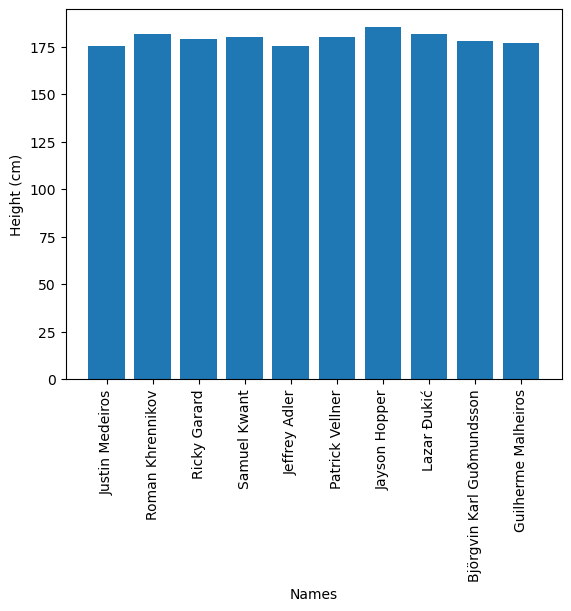

In [238]:
top10 = df_games_info_competitors[df_games_info_competitors['year'] == 2022].head(10)

# create a bar chart of the height data
plt.bar(top10['competitorName'], top10['heightInCm'],)

# add x-axis and y-axis labels
plt.xlabel('Names')
plt.ylabel('Height (cm)')

# rotate the x-axis labels
plt.xticks(rotation=90)

plt.show()

In [252]:
# Create separate dataframes for each gender
male_df = df_games_info_competitors[df_games_info_competitors['gender'] == 'M']
female_df = df_games_info_competitors[df_games_info_competitors['gender'] == 'F']

In [253]:
df_games_info_competitors['gender'].unique()

array(['M', 'F'], dtype=object)

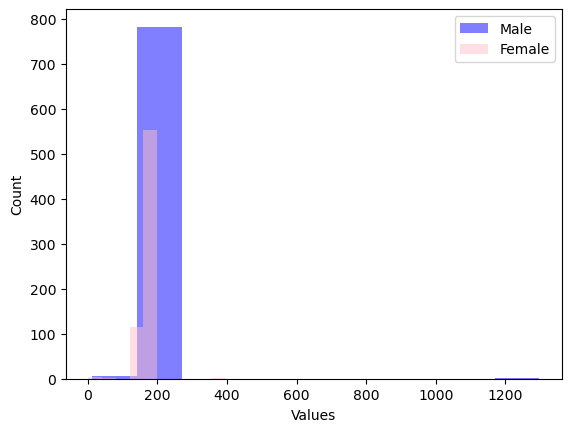

In [254]:
# Plot the histograms
plt.hist(male_df['heightInCm'], color='blue', alpha=0.5, label='Male')
plt.hist(female_df['heightInCm'], color='pink', alpha=0.5, label='Female')

# Add legend and labels
plt.legend()
plt.xlabel('Values')
plt.ylabel('Count')

# Show the plot
plt.show()

In [258]:
male_df[male_df['heightInCm'] == male_df['heightInCm'].max()]

,competitorId,competitorName,firstName,lastName,status,postCompStatus,gender,profilePicS3key,countryOfOriginCode,countryOfOriginName,...,divisionId,affiliateId,affiliateName,age,height,weight,teamCaptain,heightInCm,weightInKg,year
285,109388,Angel Orozco,Angel,Orozco,CUT,,M,men-square.jpg,,,...,1,None,,28,511 in,205 lb,0,1297.9,93.0,2009


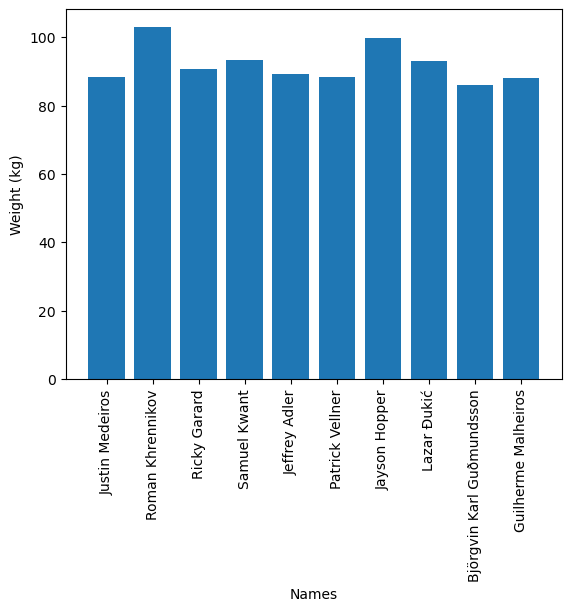

In [31]:
top10 = df_games_info_competitors.head(10)

# create a bar chart of the height data
plt.bar(top10['competitorName'], top10['weightInKg'],)

# add x-axis and y-axis labels
plt.xlabel('Names')
plt.ylabel('Weight (kg)')

# rotate the x-axis labels
plt.xticks(rotation=90)

plt.show()

In [619]:
def games_info_scores(year=2022, division=1):
    
    """

        This function uses the functions games_json_dump and games_info to get events score information for 
        the specified Crossfit Games year and division returned as a Pandas dataframe.
            
        Parameters:
            - year is from 2007 and to current
            - division is 1 for male, 2 for female and 0 for both

    """   
    
    # create a dataframe to store the scores
    df_games_info_scores = pd.DataFrame()
    # collecting data on the specified games session
    #game_info_call = games_info(year=year,division=division)
    # determining what division value we need
    if division == 1:
        division_value = [1]
    elif division == 2:
        division_value = [2]
    # else we just take both divisions
    else:
        division_value = [1,2]

    # iterate over division_value
    for current_division in range(0,len(division_value)):
        # collecting data on the specified games session
        info_response = games_info(year=year,division=division_value[current_division])
        # iterate to solve for when pages are more than 1
        if info_response[1] > 1:
            for page in range(1, info_response[1] + 1):
                # call webservice to get get the json
                response = games_json_dump(year=year,division=division_value[current_division],page=page)
                if page == info_response[1]: # if we are on the final page
                    for competitors_on_last_page in range(0, info_response[2] - (info_response[1] - 1) * 50): # there are currently 50 results per page
                        # parse json to where we want to be 
                        scores_json = response['leaderboardRows'][competitors_on_last_page]['scores']
                        df_temp = pd.json_normalize(scores_json)
                        # adding columns to dataframe so other data can be joined in a relational model
                        df_temp['competitorId'] = response['leaderboardRows'][competitors_on_last_page]['entrant']['competitorId']
                        df_temp['year'] = year
                        df_temp['division'] = division_value[current_division]
                        # Concatenate the DataFrame with the existing DataFrame
                        df_games_info_scores = pd.concat([df_games_info_scores, df_temp], ignore_index=True)
                else:
                    for competitor_not_on_last_page in range(0,50): # there are currently 50 results per page
                        # parse json to where we want to be
                        scores_json = response['leaderboardRows'][competitor_not_on_last_page]['scores']
                        df_temp = pd.json_normalize(scores_json)
                        # adding columns to dataframe so other data can be joined in a relational model
                        df_temp['competitorId'] = response['leaderboardRows'][competitor_not_on_last_page]['entrant']['competitorId']
                        df_temp['year'] = year
                        df_temp['division'] = division_value[current_division]
                        # Concatenate the DataFrame with the existing DataFrame
                        df_games_info_scores = pd.concat([df_games_info_scores, df_temp], ignore_index=True)
        # else when total_pages on the leaderbord is just one
        else:
        # call webservice to get get the json
            response = games_json_dump(year=year,division=division_value[current_division],page=1)
            for competitor in range(0,info_response[2]):
                # parse json to where we want to be
                scores_json = response['leaderboardRows'][competitor]['scores']
                df_temp = pd.json_normalize(scores_json)
                # adding columns to dataframe so other data can be joined in a relational model
                df_temp['competitorId'] = response['leaderboardRows'][competitor]['entrant']['competitorId']
                df_temp['year'] = year
                df_temp['division'] = division_value[current_division]
                # Concatenate the DataFrame with the existing DataFrame
                df_games_info_scores = pd.concat([df_games_info_scores, df_temp], ignore_index=True)

    # A lot of transformation of the data in df_games_info_competitors is needed
     
    # transforming the rank column so we can change rank to a numerical column
    df_games_info_scores.loc[df_games_info_scores['rank'] == 'CUT', 'rankReason'] = 'CUT'
    df_games_info_scores.loc[df_games_info_scores['rank'] == 'WD', 'rankReason'] = 'WD'
    df_games_info_scores.loc[df_games_info_scores['rank'] == 'DNF', 'rankReason'] = 'DNF'
    new_rank = 0
    df_games_info_scores.loc[df_games_info_scores['rank'].isin(['CUT', 'WD', 'DNF']), 'rank'] = new_rank

    # transform columns into numerical when relevant
    df_games_info_scores = convert_object_columns_to_numeric(df_games_info_scores)

    # new column to get the weight in kg of the event is a weighlifting event
    df_games_info_scores['scoreIsWeightInKg'] = df_games_info_scores['scoreDisplay'].apply(lb_to_kg)
    
    # return the final dataframe
    return(df_games_info_scores)

In [540]:
def games_info_scores_multiple(year_from=2021, year_too=2022, division=1):
             
    """

        This function uses the games_info_scores function to get information on Crossfit Games 
        scores for multiple years returned as a Pandas dataframe.

        Parameters:
            - year is from 2007 and to current
            - division is 1 for male, 2 for female and 0 for both

    """   

    # error handling for function parameters
    if not isinstance(year_from, int):
        raise TypeError("year_from should be an integer")
    # error handling for function parameters
    if not isinstance(year_too, int):
        raise TypeError("year_too should be an integer")
    if not isinstance(division, int):
        raise TypeError("division should be an integer")
            
    # create a dataframe to store info
    df_games_info_scores_multiple = pd.DataFrame()
        
    # iterate over the selected years
    for year in range(year_from, year_too + 1):
        df_temp = games_info_scores(year,division)
        df_temp['year'] = year
        df_games_info_scores_multiple = pd.concat([df_games_info_scores_multiple, df_temp], ignore_index=True)

    return(df_games_info_scores_multiple)

In [620]:
df_games_info_scores_multiple = games_info_scores_multiple(2007,2022,0)

In [623]:
df_games_info_scores_multiple.head()

,ordinal,rank,score,valid,scoreDisplay,scoreIdentifier,mobileScoreDisplay,scaled,video,heat,lane,breakdown,competitorId,year,division,rankReason,scoreIsWeightInKg
0,1,2.0,95,1.0,13:39,75881c2cd249b98185a8,NaN,0,0,NaN,NaN,95 pts,164070,2007,1,NaN,NaN
1,2,2.0,95,1.0,20:45,bf9d6716056044146079,NaN,0,0,NaN,NaN,95 pts,164070,2007,1,NaN,NaN
2,3,11.0,82,1.0,906.4 lb,a355dcd3303b9b861ba0,NaN,0,0,NaN,NaN,82 pts,164070,2007,1,NaN,411.0
3,1,1.0,100,1.0,13:07,ed155ea36b3781f16914,NaN,0,0,NaN,NaN,100 pts,57785,2007,1,NaN,NaN
4,2,3.0,90,1.0,22:00,b25717e51efa6f0d783d,NaN,0,0,NaN,NaN,90 pts,57785,2007,1,NaN,NaN
